# Spectroscopy Evaluation


In [41]:
%load_ext autoreload
%autoreload 2
    
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

%matplotlib ipympl

from pyeval import TransformDataset, GzipPickleDataset, FixedSpotHistogramEvaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
dataset = GzipPickleDataset("/tmp/AA_clock_spect_0G")
len(dataset)

767

Let us first collect the parameters:

In [56]:
params = TransformDataset(dataset, lambda x: {key: value for (key, value) in x.items() if isinstance(value, float)})

In [75]:
df = pd.DataFrame(list(params))
df.head()

,run,TC_systime_sec,f_blue_big_sideband,f_blue_IMG_AOM,f_2DMOT_AOM,amp_2DMOT_AOM,f_xSlower_AOM,f_ZS_AOM,amp_ZS_AOM,f_green_big_sideband,...,green_MOT_top_PD_voltage_bluegreen_imaging,green_MOT_top_PD_voltage_cMOT_ramp_final,green_MOT_top_PD_voltage_tweezer_loading_ramp_final,MOT_beams_bluegreen_imaging_scaling_factor,blue_IMG_PD_voltage,f_blue_blow_out_AOM,amp_AOM_blue_blow_out,blue_blow_out_PD_voltage,blue_blow_out_duration,cam_exposure
0,1164.0,6.065387e+13,478.0,394.16,354.0,0.74,304.0,115.0,1.0,481.75,...,0.0054,0.00154,0.00141,1.0,0.03,375.0,0.4,0.05,0.03,0.11
1,1165.0,6.065484e+13,478.0,394.16,354.0,0.74,304.0,115.0,1.0,481.75,...,0.0054,0.00154,0.00141,1.0,0.03,375.0,0.4,0.05,0.03,0.11
2,1166.0,6.065581e+13,478.0,394.16,354.0,0.74,304.0,115.0,1.0,481.75,...,0.0054,0.00154,0.00141,1.0,0.03,375.0,0.4,0.05,0.03,0.11
3,1167.0,6.065679e+13,478.0,394.16,354.0,0.74,304.0,115.0,1.0,481.75,...,0.0054,0.00154,0.00141,1.0,0.03,375.0,0.4,0.05,0.03,0.11
4,1168.0,6.065776e+13,478.0,394.16,354.0,0.74,304.0,115.0,1.0,481.75,...,0.0054,0.00154,0.00141,1.0,0.03,375.0,0.4,0.05,0.03,0.11


and let us get rid of every column/parameter which doesn't change

In [76]:
df = df.loc[:, df.nunique(dropna=False).ne(1)]
df.head()

,run,TC_systime_sec,f_yellow_AOM
0,1164.0,6.065387e+13,78.465467
1,1165.0,6.065484e+13,78.465800
2,1166.0,6.065581e+13,78.466133
3,1167.0,6.065679e+13,78.466467
4,1168.0,6.065776e+13,78.466800


now we move on to the probabilities

In [77]:
evaluation = FixedSpotHistogramEvaluation(spot_num=16, spot_radius=3, spot_counts_bins=100)
evaluation.evaluate(dataset)

In [78]:
spots = evaluation.spots.copy()
spots[:, 0, :] |= spots[:, 1, :] 

In [79]:
prop = spots[:, 1].sum(axis=-1) / spots[:, 0].sum(axis=-1)
prop.shape

(767,)

and add them to the dataframe

In [80]:
df['probability'] = prop
df.head()

,run,TC_systime_sec,f_yellow_AOM,probability
0,1164.0,6.065387e+13,78.465467,1.000000
1,1165.0,6.065484e+13,78.465800,1.000000
2,1166.0,6.065581e+13,78.466133,1.000000
3,1167.0,6.065679e+13,78.466467,1.000000
4,1168.0,6.065776e+13,78.466800,0.833333


<Axes: xlabel='f_yellow_AOM', ylabel='probability'>

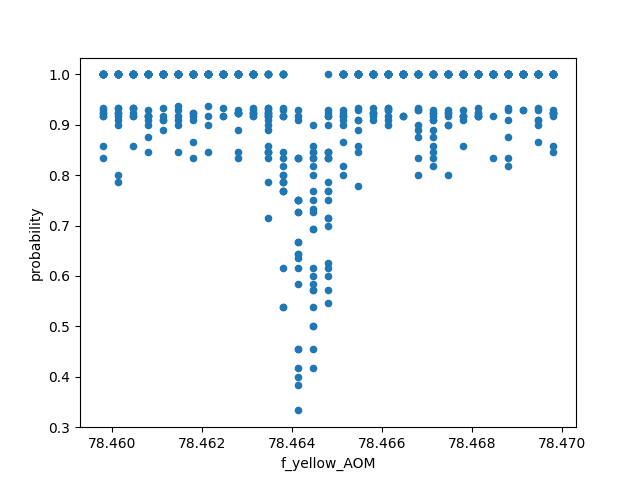

In [82]:
df.plot(x='f_yellow_AOM', y='probability', kind='scatter')

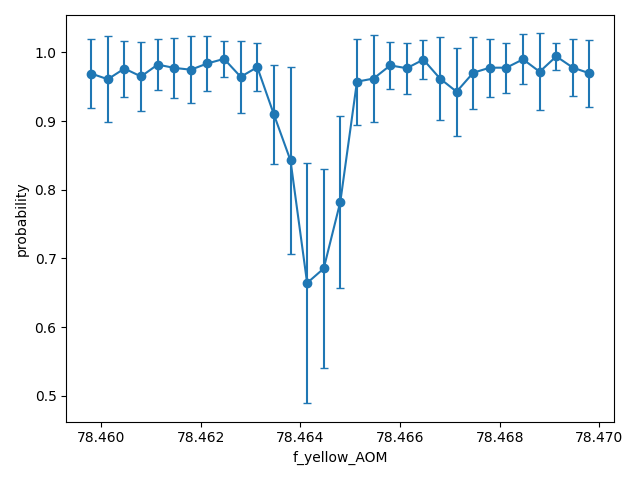

In [83]:
g = (df.groupby('f_yellow_AOM')['probability']
       .agg(mean='mean', std='std', n='size')
       .reset_index()
       .sort_values('f_yellow_AOM'))

plt.figure()
plt.errorbar(g['f_yellow_AOM'], g['mean'], yerr=g['std'].fillna(0), fmt='o-', capsize=3)
plt.xlabel('f_yellow_AOM')
plt.ylabel('probability');
plt.tight_layout()
plt.show()

In [84]:
from scipy.optimize import curve_fit

x = g['f_yellow_AOM'].to_numpy(float)
y = g['mean'].to_numpy(float)
std = g['std'].to_numpy(float)
n = g['n'].to_numpy(float)

# Use standard error of the mean for fit weights
sigma = std / np.sqrt(np.maximum(n, 1))
pos = np.isfinite(sigma) & (sigma > 0)
if not pos.any():
    sigma = None
else:
    # replace zeros/NaNs with a typical positive value
    sigma = np.where(pos, sigma, np.median(sigma[pos]))

def neg_lorentz(x, x0, gamma, A, offset):
    # offset - A * gamma^2 / ((x - x0)^2 + gamma^2);  A>=0, gamma>0
    return offset - A * (gamma**2) / ((x - x0)**2 + gamma**2)

# Initial guesses
x0_0 = x[np.argmin(y)]
offset_0 = np.max(y)
A_0 = max(offset_0 - np.min(y), 1e-9)
gamma_0 = 0.1 * (x.max() - x.min()) if x.max() > x.min() else 1.0
p0 = [x0_0, gamma_0, A_0, offset_0]

# Constrain gamma>0, A>=0
bounds = ([-np.inf, 1e-12, 0.0, -np.inf], [np.inf, np.inf, np.inf, np.inf])

popt, pcov = curve_fit(neg_lorentz, x, y, p0=p0, sigma=sigma,
                       absolute_sigma=True, bounds=bounds, maxfev=20000)
perr = np.sqrt(np.diag(pcov))
x0, gamma, A, offset = popt

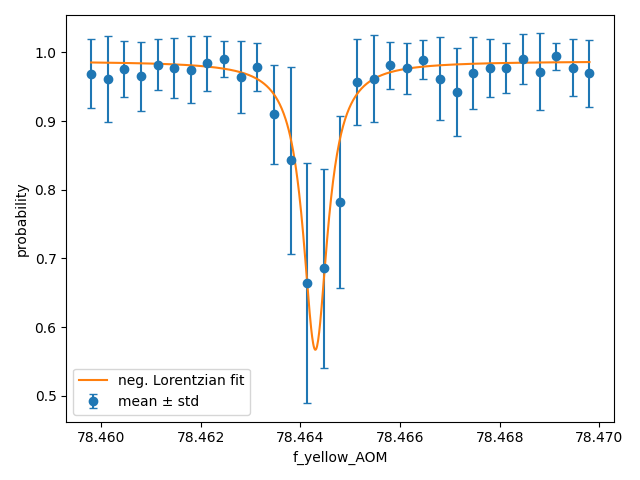

In [86]:
xs = np.linspace(x.min(), x.max(), 1000)
yf = neg_lorentz(xs, *popt)

plt.figure()
plt.errorbar(x, y, yerr=std, fmt='o', capsize=3, label='mean ± std')
plt.plot(xs, yf, '-', label='neg. Lorentzian fit')
plt.xlabel('f_yellow_AOM')
plt.ylabel('probability')
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
print(f"x0 = {x0:.6g} ± {perr[0]:.2g}")
print(f"gamma = {gamma:.6g} ± {perr[1]:.2g}")
print(f"A = {A:.6g} ± {perr[2]:.2g}")
print(f"offset = {offset:.6g} ± {perr[3]:.2g}")

x0 = 78.4643 ± 2.2e-05
gamma = 0.000299454 ± 3.5e-05
A = 0.42025 ± 0.045
offset = 0.987255 ± 0.002
